# How to use this notebook

1) You can run through the entire notebook by clicking the **>>** icon above (it will reset the notebook and then run everything as-is. You can also run each cell individually _in order_ by clicking inside the cell and hitting the **>| Run** button above for each cell. This is the same as clicking inside the cell, holding down the _Shift_ key, and pressing _Enter_.

2) Data will be updated (JHU only updates the data repository once per day, so don't bother checking multiple times per day!)

3) Change variables to look at data that is of interest to you! Details for variables that you can change are listed in the section before the cell where they can be changed

4) Share it if you like! I may add additional resources/plots as time goes on.
    - https://mybinder.org/v2/gh/neuralabc/COVID-19/master

In [19]:
import pandas as pd
import numpy as np
import datetime as dt
from scipy.signal import savgol_filter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
def dateconvert(datestring,fmt='%m/%d/%y'):
    #convert string to datetime object
    if isinstance(datestring,str):
        return dt.datetime.strptime(str(datestring),fmt)
    else:
        return [dt.datetime.strptime(str(ds),fmt) for ds in datestring]
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#this is the confirmed data, updated daily
raw_csv = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
df = pd.read_csv(raw_csv,header=0)
df.head()
col_before_dates = 'Long' #this is the last column before the dates start
df['Country/Region'] = df['Country/Region'].replace('Taiwan*','Taiwan') #remove extra formatting for Taiwan
print("Countries: {}".format(sort(unique(df['Country/Region']))))

Countries: ['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'Brunei' 'Bulgaria' 'Burkina Faso' 'Burma' 'Burundi'
 'Cabo Verde' 'Cambodia' 'Cameroon' 'Canada' 'Central African Republic'
 'Chad' 'Chile' 'China' 'Colombia' 'Comoros' 'Congo (Brazzaville)'
 'Congo (Kinshasa)' 'Costa Rica' "Cote d'Ivoire" 'Croatia' 'Cuba' 'Cyprus'
 'Czechia' 'Denmark' 'Diamond Princess' 'Djibouti' 'Dominica'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea'
 'Eritrea' 'Estonia' 'Eswatini' 'Ethiopia' 'Fiji' 'Finland' 'France'
 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana' 'Greece' 'Grenada'
 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti' 'Holy See'
 'Honduras' 'Hungary' 'Iceland' 'India' 'Indonesia' 'Iran' 'Iraq'
 'Ireland' 'Israel' 'Italy' 'Jamaica' 

# Create plot of regions within an individual country
- this only works for countries where data is available for multiple regions, otherwise it will plot the total for the country
- Change the country_name (e.g., replace 'Canada' with 'United Kingdom')
- Setup a list of provinces/states/regions within a country with province_subset (e.g. if country_name = 'Canada' then you can set province_subset = ['Ontario','Quebec'])
    - if you do not know whhat provinces are in a country, set the country and then run the cell once. It will print a list of the available provinces
- You can also set the date to begin plotting by setting the two variables set_start_plotting_date (True to do this, or set to False to not use it) and then 
    - case_thresh to set the number of cases to begin plotting from

In [3]:
## Choose the country and regin (if available)
country_name = 'Canada' #choose a single country by name (from list above)
province_subset = None #None for all provinces, or choose a subset of provinces as a list; e.g., ['Ontario','Quebec']
set_start_plotting_date = True #set to true if you would like to have plotting begin one day before a certain number of cases
case_thresh = 100 #case threshold

#generate the dataframe for the plotting
df_p = df[df['Country/Region']==country_name]
provinces = df_p['Province/State']
print("Available Province/State list for {}: {}".format(country_name,list(provinces)))

Available Province/State list for Canada: ['Alberta', 'British Columbia', 'Grand Princess', 'Manitoba', 'New Brunswick', 'Newfoundland and Labrador', 'Nova Scotia', 'Ontario', 'Prince Edward Island', 'Quebec', 'Saskatchewan', 'Diamond Princess', 'Northwest Territories', 'Yukon']


Regions: 
['Alberta' 'British Columbia' 'Grand Princess' 'Manitoba' 'New Brunswick'
 'Newfoundland and Labrador' 'Nova Scotia' 'Ontario'
 'Prince Edward Island' 'Quebec' 'Saskatchewan' 'Diamond Princess'
 'Northwest Territories' 'Yukon']


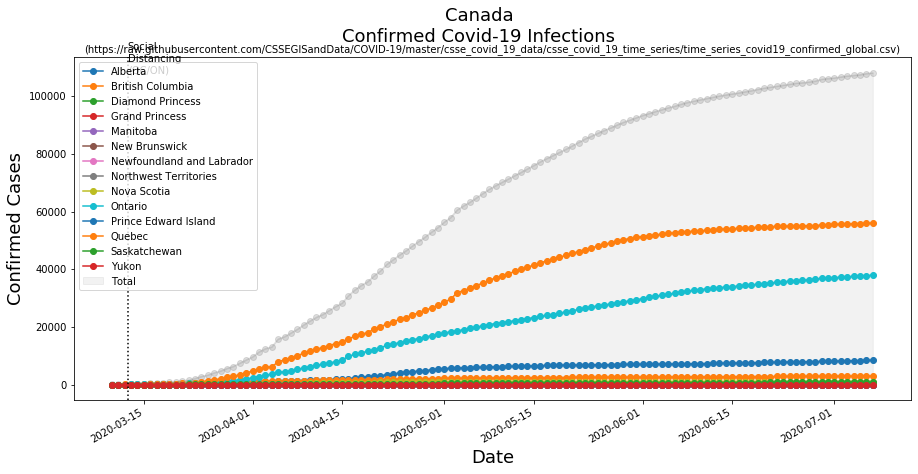

In [4]:
#generate the dataframe for the plotting, if you provided a list for province_subset then this gets filtered here
if not df_p['Province/State'].isna().any(): 
    if province_subset is not None:
        df_p = df_p[df_p['Province/State'].isin(province_subset)]
    
if df_p.shape[0] == 0:
    print('Something has gone wrong!\nMost likely you did not spell the Country or Province/State name(s) correctly')
    
col_start_idx = df_p.columns.tolist().index(col_before_dates)+1

if df_p['Province/State'].isin(['Ontario','Quebec']).any():
    #social distancing date (ish, Quebec-based)
    social_distancing_date = '2020-03-12-12' #setbetween the 12th and 13th, as the policy came into effect on the 13th 
else:
    social_distancing_date = None
    
df_p.head()

if len(provinces) == 1:
    print('Country totals are the only data available for {}'.format(country_name))
    df_p_is_total = True
else:
    df_p_is_total = False
print("Regions: ")
print(provinces.values)

##generate a total and set this up for plotting, also create the ability to start the plot at a given date
#create a total, which causes issues due to ... pandas
if not df_p_is_total:
    df_total = df_p.sum()
    df_total = df_total.reset_index().T
    #silly pandas annoyances...
    t_x = dateconvert(df_total.iloc[0,col_start_idx:].tolist())
    t_y = np.array(df_total.iloc[1,col_start_idx:]).astype(int) 
else:
    t_x = dateconvert(df_p.iloc[:,col_start_idx:].columns)
    t_y = np.squeeze(df_p.iloc[:,col_start_idx:])

#setup a start date for plotting, in this case one time point prior to when we hit 50 cases in the country
if set_start_plotting_date:
    start_idx = np.where(t_y>case_thresh)[0][0]-1
else:
    start_idx = 0
    
t_x = t_x[start_idx:]
t_y = t_y[start_idx:]
# plot_start_date 

plt.figure(figsize=(15,7))
_t=plt.suptitle('{}\nConfirmed Covid-19 Infections'.format(country_name),fontsize=18)
_t=plt.title('({})'.format(raw_csv),fontsize=10)

plt.plot(t_x,t_y,'-o',color='grey',alpha=0.25)
plt.fill_between(t_x,t_y,interpolate=False,color='grey',alpha=0.1,label='Total')

if not df_p_is_total:
    for province in sort(unique(df_p['Province/State'])):
        df_pp = df_p[df_p['Province/State']==province]
        x = dateconvert(df_pp.iloc[:,col_start_idx+start_idx:].columns)
        y = np.squeeze(df_pp.iloc[:,col_start_idx+start_idx:])
        plt.plot(x,y,'o-',label=province)

#add the legend, but only if there are less than 20 lines on the plot
if len(unique(df_p['Province/State']))<=20: 
    plt.legend()
plt.gcf().autofmt_xdate()
_t=plt.xlabel("Date",fontsize=18)
_t=plt.ylabel("Confirmed Cases",fontsize=18)
if social_distancing_date is not None:
    _p=plt.axvline(x=social_distancing_date,color='k',linestyle=':')
    _t=plt.text(social_distancing_date,t_y.max()-50,"Social\nDistancing\n(QC/ON)")

# Plot multiple countries in the same timeseries plot
- additional options to scale by total population or population density of the country
- as before, run each cell
    - the third cell after this one has additional instructions for variables that can be changed

In [5]:
###### grab country pop numbers for relative plotting
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen

url = 'https://www.worldometers.info/world-population/population-by-country/'
hdr = {'User-Agent': 'Mozilla/5.0'}
# source = urllib.request.urlopen(url)
# soup = BeautifulSoup(source,'html.parser')

hdr = {'User-Agent': 'Mozilla/5.0'}
req = Request(url,headers=hdr)
page = urlopen(req)
soup = BeautifulSoup(page)

table = soup.find('table')
table_rows = table.find_all('tr')

res = []
for tr in table_rows:
    #get the column names first
    if table_rows.index(tr) == 0:
        col_names = [ th.getText().strip() for th in tr.find_all('th') if th.getText().strip() != '' ]  
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td]
    if row:
        res.append(row)
df_pop = pd.DataFrame(res,columns=col_names)
print(df_pop.shape)
df_pop.rename(columns={"Country (or dependency)":"Country/Region",},inplace=True)  #to use same naming convention as df
print(sort(df_pop['Country/Region']))
df_pop.head()

(235, 12)
['Afghanistan' 'Albania' 'Algeria' 'American Samoa' 'Andorra' 'Angola'
 'Anguilla' 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba'
 'Australia' 'Austria' 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh'
 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin' 'Bermuda' 'Bhutan'
 'Bolivia' 'Bosnia and Herzegovina' 'Botswana' 'Brazil'
 'British Virgin Islands' 'Brunei' 'Bulgaria' 'Burkina Faso' 'Burundi'
 'Cabo Verde' 'Cambodia' 'Cameroon' 'Canada' 'Caribbean Netherlands'
 'Cayman Islands' 'Central African Republic' 'Chad' 'Channel Islands'
 'Chile' 'China' 'Colombia' 'Comoros' 'Congo' 'Cook Islands' 'Costa Rica'
 'Croatia' 'Cuba' 'Curaçao' 'Cyprus' 'Czech Republic (Czechia)'
 "Côte d'Ivoire" 'DR Congo' 'Denmark' 'Djibouti' 'Dominica'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea'
 'Eritrea' 'Estonia' 'Eswatini' 'Ethiopia' 'Faeroe Islands'
 'Falkland Islands' 'Fiji' 'Finland' 'France' 'French Guiana'
 'French Polynesia' 'Gabon' 'Gambia' 'Georgia' 'Germany' '

,#,Country/Region,Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,1,China,"1,439,323,776",0.39 %,"5,540,090",153,"9,388,211","-348,399",1.7,38,61 %,18.47 %
1,2,India,"1,380,004,385",0.99 %,"13,586,631",464,"2,973,190","-532,687",2.2,28,35 %,17.70 %
2,3,United States,"331,002,651",0.59 %,"1,937,734",36,"9,147,420","954,806",1.8,38,83 %,4.25 %
3,4,Indonesia,"273,523,615",1.07 %,"2,898,047",151,"1,811,570","-98,955",2.3,30,56 %,3.51 %
4,5,Pakistan,"220,892,340",2.00 %,"4,327,022",287,"770,880","-233,379",3.6,23,35 %,2.83 %


In [6]:
#make a copy of our original df, change some country names so that we can merge, then merge with dataframe that 
# includes the population

no = ['US', 'Korea, South', 'Korea, North'] #origin
nt = ['United States', 'South Korea', 'North Korea'] #target #There are likely more
df_mod = df.copy()
df_mod = df_mod.groupby('Country/Region').sum().reset_index()
for idx,n in enumerate(no):
    df_mod['Country/Region'] = df_mod['Country/Region'].replace(no[idx],nt[idx])

# df_mod['Country/Region'] = df_mod['Country/Region'].replace('*','')
## merge
#put df_mod at the end so that we end on the last timepoint
df_all = df_pop.merge(df_mod,right_on='Country/Region',left_on='Country/Region') 
# df_all.rename(columns={"Country (or dependency)":"Country/Region",},inplace=True) 
print(df_all.shape)
df_all.head()


(176, 182)


,#,Country/Region,Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,...,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20,7/7/20
0,1,China,"1,439,323,776",0.39 %,"5,540,090",153,"9,388,211","-348,399",1.7,38,...,84757,84780,84785,84816,84830,84838,84857,84871,84889,84917
1,2,India,"1,380,004,385",0.99 %,"13,586,631",464,"2,973,190","-532,687",2.2,28,...,548318,566840,585481,604641,625544,648315,673165,697413,719664,742417
2,3,United States,"331,002,651",0.59 %,"1,937,734",36,"9,147,420","954,806",1.8,38,...,2549294,2590668,2636414,2687588,2742049,2795361,2841241,2891124,2936077,2996098
3,4,Indonesia,"273,523,615",1.07 %,"2,898,047",151,"1,811,570","-98,955",2.3,30,...,54010,55092,56385,57770,59394,60695,62142,63749,64958,66226
4,5,Pakistan,"220,892,340",2.00 %,"4,327,022",287,"770,880","-233,379",3.6,23,...,206512,209337,213470,217809,221896,221896,225283,231818,234509,237489


# Plot multiple countries with the same time scaling (since nth case) and/or relative to total population or population density
- Change list of countries to include in plot
- Change number of cases for zeroing the data (set cases_for_zeroing to, for e.g., 50 or 100)
- set relative_to_pop and/or relative_to_density to True/False to select or deselect them
- set plot_country_names to False if they become too overlapped or difficult to read
- use_log_scale toggle log scaling of y-axis (num/proportion/proportion-density of cases)
- max_number_days to cut the plot off after a certain number of days (includes zeroth day)

All changes will be reflected in the text within the plots


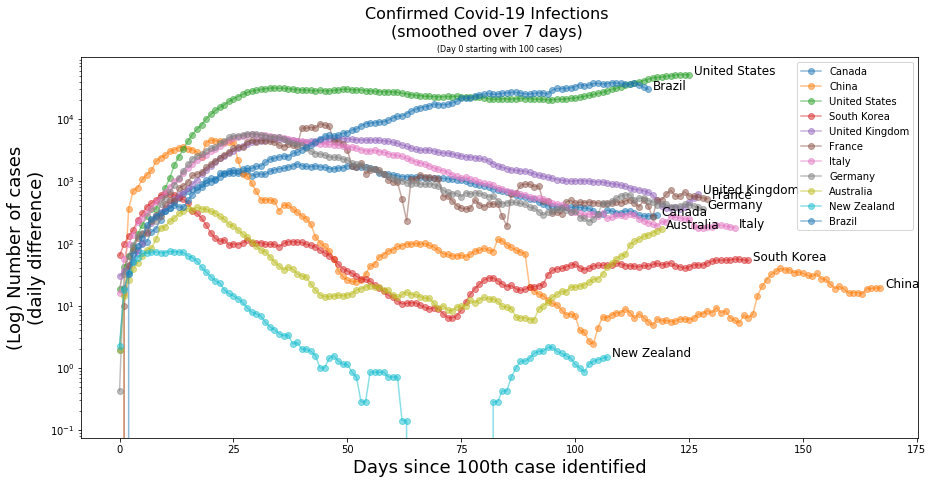

In [54]:
countries = ['Canada','China','United States','South Korea','United Kingdom','France','Italy',
             'Germany','Australia','New Zealand','Brazil']
# countries = ['Canada','Australia','New Zealand','United States']
cases_for_zeroing = 100 #number of cases (per country) to zero each country to
relative_to_pop = False #plot relative number of cases over time (divide by population)
relative_to_density = False
plot_country_names = True #put the country names beside the timeseries
use_log_scale = True
max_number_days = None #50 #maximum number of days to cutoff the data at, use None for no cutoff, this includes the 0th day
daily_difference = True
density_col = 'Density (P/Km²)'
pop_col = 'Population (2020)'
smooth_data = True #smooth data in the last step with a 1st order savgol filter
smooth_days = 7 #smooth the data with a savgol filter


if relative_to_density:
    relative_to_pop = False #we are already relative to pop :)
if smooth_data:
    smooth_txt = "smoothed over {} days".format(smooth_days)

plt.figure(figsize=(15,7))
_t=plt.suptitle('Confirmed Covid-19 Infections\n({})'.format(smooth_txt),fontsize=16)

if relative_to_pop:
    _t=plt.title('(Day 0 starting with {} cases & Relative to country population)'.format(cases_for_zeroing),fontsize=8)
elif relative_to_density:
    _t=plt.title('(Day 0 starting with {} cases & Relative to country density)'.format(cases_for_zeroing),fontsize=8)
else:
    _t=plt.title('(Day 0 starting with {} cases)'.format(cases_for_zeroing),fontsize=8)

for country in countries:
    #convert population (includes ","s) to an integer
    pop = int(df_all[df_all['Country/Region'] == country][pop_col].values[0].replace(',',''))
    density = float(df_all[df_all['Country/Region'] == country][density_col].values[0])
    #get index for where the timeseries data starts (ends @ last column)
    df_all_col_start_idx = df_all.columns.tolist().index(col_before_dates)+1
    dates = df_all[df_all['Country/Region'] == country].columns[df_all_col_start_idx:].tolist()
    ts = df_all[df_all['Country/Region'] == country].iloc[0,df_all_col_start_idx:].values
    idx_offset = np.where(ts>=cases_for_zeroing)[0][0]
    dates = dateconvert(dates[idx_offset:])
    ts = np.array(ts[idx_offset:])
    if relative_to_pop:
        ts = ts/pop
    elif relative_to_density:
        ts = ts/density
    if daily_difference:
        ts = np.insert(np.diff(ts),0,0)
    if smooth_data:
        ts = savgol_filter(ts, smooth_days, 1) 
    #compute the days since (i think each day is reported in all cases, but just to be sure)
    days = [0]
    for dt_diff in np.diff(dates):
        days.append(dt_diff.days) #converted to datetime obj (delta)
    days = np.cumsum(days)

    if (max_number_days is not None) and (days.max() > max_number_days):
        idx_offset = np.where(days<=max_number_days)[0][-1]
        days = days[:idx_offset]
        ts = ts[:idx_offset]

    plt.plot(days,ts,'o-',label=country,alpha=0.5)
    if plot_country_names:
        plt.text(days[-1]+1,ts[-1],country,fontsize=12)
plt.xlabel('Days since {}th case identified'.format(cases_for_zeroing),fontsize=18)

if use_log_scale:
    log_txt = "(Log) "
else:
    log_txt = ""
if daily_difference:
    log_tail = "\n(daily difference)"
else:
    log_tail = ""
if relative_to_pop:
    plt.ylabel('{}Number of cases / total population\n(proportion){}'.format(log_txt,log_tail),fontsize=18)
elif relative_to_density:
    plt.ylabel('{}Number of cases / population density {}{}'.format(log_txt,density_col.replace('Density ',''),log_tail),fontsize=18)
else:
    plt.ylabel('{}Number of cases{}'.format(log_txt,log_tail),fontsize=18)
plt.legend()
if use_log_scale:
    plt.gca().set_yscale('log')

# Plot the most recent snapshot of data in approximately the correct spatial locations where they would be on a world map
- There are no variables to change here, just run it

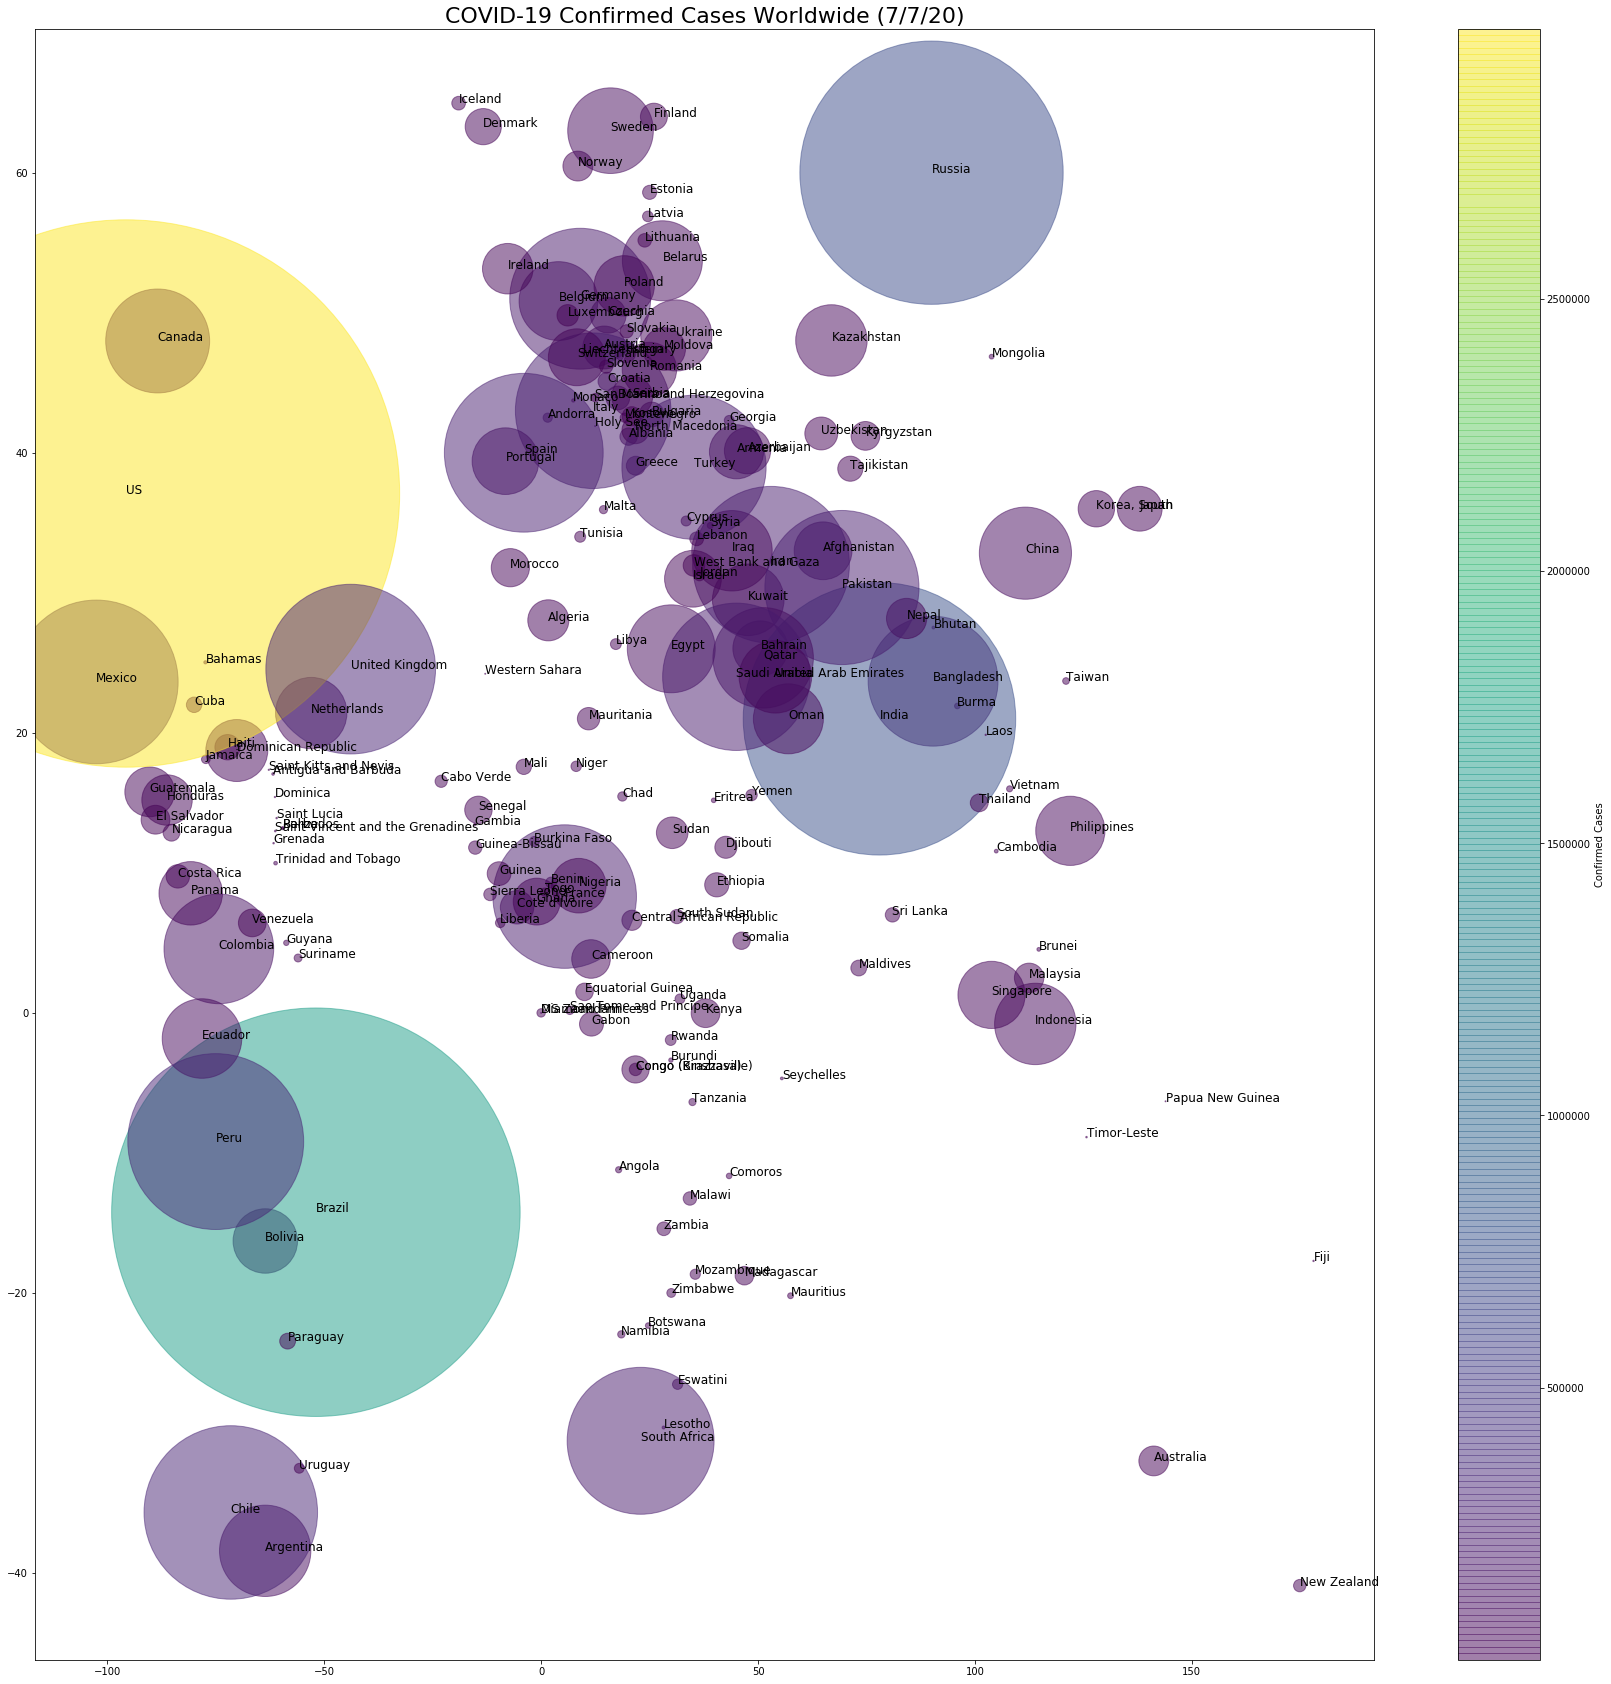

In [56]:
# Grab most recent data and plot as a snapshot, hopefully with spatial information
scale_factor = 10 #just used to shrink the bubbles so that they don't fill the screen
most_recent_data = df.columns[-1]
df_country_lat_long = df[['Country/Region','Lat','Long',most_recent_data]]
# df_country_cases = df[['Country/Region',most_recent_data]]
# df_country_lat_long = df_country_lat_long.groupby('Country/Region',as_index=False).median()
df_country_lat_long = df_country_lat_long.groupby('Country/Region',
                                                  as_index=False).agg({'Lat':mean, 
                                                                       'Long':mean, 
                                                                       most_recent_data:sum}) #gives approximate location
plt.figure(figsize=(30,30))
plt.title('COVID-19 Confirmed Cases Worldwide ({})'.format(most_recent_data),fontsize=22)
colors = df_country_lat_long[most_recent_data]/df_country_lat_long[most_recent_data].max()
plt.scatter(df_country_lat_long.Long,df_country_lat_long.Lat,
            s=df_country_lat_long[most_recent_data]/scale_factor,c=df_country_lat_long[most_recent_data],
            cmap='viridis',alpha=.5)
cb = plt.colorbar(label='Confirmed Cases')
for country in df_country_lat_long['Country/Region']:
    x,y=df_country_lat_long[df_country_lat_long['Country/Region']==country][['Lat','Long']].values.flatten()
    plt.text(y,x,country,fontsize=12)

# ================================
## Nothing interesting to see after here!
# ================================


In [ ]:
###### MORE UP TO DATE INFORMATION, but no lat/long so it will have to be merged with above df

In [9]:
from bs4 import BeautifulSoup
import urllib.request

url = 'https://www.worldometers.info/coronavirus/'
req = Request(url,headers=hdr)
page = urlopen(req)
soup = BeautifulSoup(page)
table = soup.find('table',attrs={'id':"main_table_countries_today"})
table_rows = table.find_all('tr')

res = []
for tr in table_rows:
    #get the column names first
    if table_rows.index(tr) == 0:
        col_names = [ th.getText().strip() for th in tr.find_all('th') if th.getText().strip() != '' ]  
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td]
    if row:
        res.append(row)
df_current = pd.DataFrame(res,columns=col_names)
df_current.head()

,"Country,Other",TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,ActiveCases,"Serious,Critical",Tot Cases/1M pop,Deaths/1M pop,1stcase
0,USA,"142,004","+18,426","2,484",+264,"4,559","134,961","2,970",429,8,Jan 20
1,Italy,"97,689","+5,217","10,779",+756,"13,030","73,880","3,906","1,616",178,Jan 29
2,Spain,"80,110","+6,875","6,803",+821,"14,709","58,598","4,165","1,713",146,Jan 30
3,Germany,"62,435","+4,740",541,+108,"9,211","52,683","1,979",745,6,Jan 26
4,France,"40,174","+2,599","2,606",+292,"7,202","30,366","4,632",615,40,Jan 23


In [ ]:
print(sort(df_current['Country,Other'].tolist()))

In [ ]:
thead = table.find_all('thead')
[th.text for th in thead]

In [ ]:
header = ['Country','Latitute','Longitude']
res = []
countries = []
for country in unique(df['Country/Region']):
    res.append(df[df['Country/Region'] == country][['Lat','Long']].mean())
    countries.append(country.strip("*").replace("S.","South").replace("St.","Saint"))

In [ ]:
countries